<a href="https://colab.research.google.com/github/sakshisubedi/CSE_256_NLP/blob/main/bert/imdb_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/CSE_256_Project

/content/drive/MyDrive/CSE_256_Project


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
df = pd.read_csv('IMDB-Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# df['sentiment'] = df['sentiment'].apply(lambda x : 1 if x=='positive' else 0)
# df.head()
reviews = df['review'].tolist()
labels = [1 if sentiment == 'positive' else 0 for sentiment in df['sentiment'].tolist()]

In [ ]:
# Split the dataset into train and test sets
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# Split the dataset into train, validation, and test sets
train_reviews, test_reviews, train_labels, test_labels = train_test_split(reviews, labels, test_size=0.2, random_state=42)
train_reviews, val_reviews, train_labels, val_labels = train_test_split(train_reviews, train_labels, test_size=0.2, random_state=42)

In [ ]:
# Load the pre-trained BERT model and tokenizer
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Tokenize the input reviews
train_tokenized_reviews = tokenizer.batch_encode_plus(
    train_reviews,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
val_tokenized_reviews = tokenizer.batch_encode_plus(
    val_reviews,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
test_tokenized_reviews = tokenizer.batch_encode_plus(
    test_reviews,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

In [ ]:
train_input_ids = train_tokenized_reviews['input_ids']
train_attention_masks = train_tokenized_reviews['attention_mask']
val_input_ids = val_tokenized_reviews['input_ids']
val_attention_masks = val_tokenized_reviews['attention_mask']
test_input_ids = test_tokenized_reviews['input_ids']
test_attention_masks = test_tokenized_reviews['attention_mask']

In [ ]:
# Convert the data into PyTorch DataLoader
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
train_dataset = TensorDataset(train_input_ids, train_attention_masks, torch.tensor(train_labels))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, torch.tensor(val_labels))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, torch.tensor(test_labels))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Set up the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
# Set up the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
num_epochs = 3
batch_size = 16

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import time

train_accuracy_values = []
train_loss_values = []
val_accuracy_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model.train()

    total_loss = 0
    total_correct = 0
    total_examples = 0

    s = time.time()

    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predictions = torch.max(logits, dim=1)
        total_correct += torch.sum(predictions == labels).item()
        total_examples += labels.size(0)

    # Calculate epoch-level loss and accuracy
    train_loss = total_loss / len(train_dataloader)
    train_accuracy = total_correct / total_examples

    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    # Print loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print("Time taken per epoch", time.time()-s)


    # Validation loop
    total_val_loss = 0.0
    total_val_correct = 0
    total_val_examples = 0

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for val_batch in val_dataloader:
            val_input_ids = val_batch[0].to(device)
            val_attention_masks = val_batch[1].to(device)
            val_labels = val_batch[2].to(device)

            # Forward pass
            val_outputs = model(input_ids=val_input_ids, attention_mask=val_attention_masks, labels=val_labels)
            val_loss = val_outputs.loss
            val_logits = val_outputs.logits

            # Update total loss
            total_val_loss += val_loss.item()

            # Calculate predictions and accuracy
            _, val_predictions = torch.max(val_logits, dim=1)
            total_val_correct += torch.sum(val_predictions == val_labels).item()
            total_val_examples += val_labels.size(0)

    # Calculate validation loss and accuracy
    val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = total_val_correct / total_val_examples

    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

    # Print loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print("Time taken per epoch", time.time()-s)


Epoch 1/3 - Loss: 0.0758, Accuracy: 0.9751
Time taken per epoch 1426.8565216064453
Epoch 1/3 - Loss: 0.0758, Accuracy: 0.9751
Time taken per epoch 1555.99964761734
Epoch 2/3 - Loss: 0.0438, Accuracy: 0.9866
Time taken per epoch 1425.0026681423187
Epoch 2/3 - Loss: 0.0438, Accuracy: 0.9866
Time taken per epoch 1554.6966154575348
Epoch 3/3 - Loss: 0.0286, Accuracy: 0.9916
Time taken per epoch 1427.2047657966614
Epoch 3/3 - Loss: 0.0286, Accuracy: 0.9916
Time taken per epoch 1556.861275434494


In [ ]:
train_loss_values, val_loss_values

([0.07577135250647553, 0.04377747927693417, 0.028578170535794926],
 [0.24000710879452528, 0.28106753527838735, 0.3160602643783204])

In [ ]:
train_accuracy_values, val_accuracy_values

([0.97509375, 0.986625, 0.99159375], [0.922375, 0.926, 0.926375])

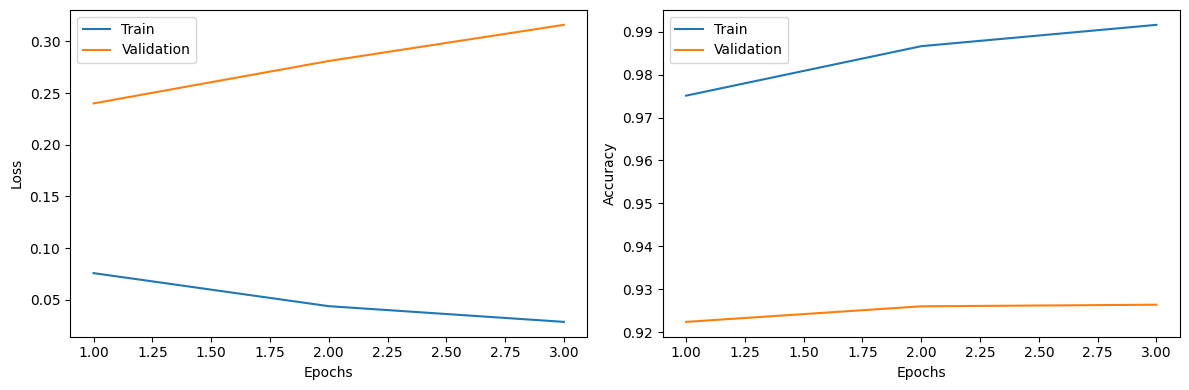

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_values, label='Train')
plt.plot(range(1, num_epochs+1), val_loss_values, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy_values, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracy_values, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing loop
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
test_total_correct = 0
test_total_examples = 0
test_predicted_labels = []

with torch.no_grad():
    for test_batch in test_dataloader:
        test_input_ids = test_batch[0].to(device)
        test_attention_mask = test_batch[1].to(device)
        test_labels = test_batch[2].to(device)

        test_outputs = model(input_ids=test_input_ids, attention_mask=test_attention_mask)
        test_logits = test_outputs.logits
        _, test_predictions = torch.max(test_logits, dim=1)
        test_total_correct += torch.sum(test_predictions == test_labels).item()
        test_total_examples += test_labels.size(0)

        test_predicted_labels.extend(test_predictions.cpu().numpy())

test_accuracy = test_total_correct / test_total_examples
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9258


In [ ]:
test_total_correct, test_total_examples

(9159, 10000)

In [ ]:
import numpy as np
test_predicted_labels = np.array(test_predicted_labels)
test_predicted_labels

array([0, 1, 0, ..., 1, 0, 1])